In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module_CFG import Data_Module_CFG
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks import ModelCheckpoint

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()

False

In [3]:


class CFG:
    
    device = dev
    
   
    use_wandb = True
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train'
    set_max_label_length = 128
    number_png_images_to_use_in_dataset=250*1000
    labels_transform='default'
    image_transform_name ='alb'
    train_val_fraction = 0.97
    vocabulary_path = 'Tokenizer/230k_ver2.json'
    load_vocabulary = True
    image_padding = True
    max_width = 1024


    batch_size = 32
    num_workers = 0
    on_gpu = False
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    
    learning_rate =  1e-5
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 64 // batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
   
    eta_min = 1e-8
    t_max = 40
    max_epochs = 35
    weight_decay =  1e-5
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations/ Image Transforms ###############
    
    # Training Aug
    
    train_transforms = [
       #A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),
                        #A.ShiftScaleRotate(shift_limit=0, scale_limit=(-.15, 0), rotate_limit=1, border_mode=0, interpolation=3, value=[255, 255, 255], p=1),
                        #A.Affine(scale=(0.6, 1.0), rotate=(-2, 2), cval=255, p=0.5),
                        #A.GridDistortion(distort_limit=0.1, border_mode=0, interpolation=3, value=[255, 255, 255], p=.5),
                        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                        A.GaussianBlur(blur_limit=(1, 1), p=0.5),
                        A.RandomBrightnessContrast(.5, (-.5, .5), True, p=0.3),
                        #A.ImageCompression(95, p=.3),
                        ToTensorV2(),
                        ]
    

    
    # Validaiton Aug
    
    val_transforms = [
        #A.Resize(patch_size, patch_size),
    #A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),

       
        ToTensorV2(),
    ]
    
    # Test Aug
    test_transforms = [
        #A.Resize(patch_size, patch_size),
      

        ToTensorV2(),
    ]
        
    
    

In [4]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module_CFG(cfg=CFG)



Train/Val Data is ready for Model loading.


In [5]:
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s + str(letter)
    return s



transform = transforms.ToPILImage()

In [6]:
model = ResNetTransformer(dataset=dataset,).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/first_test_collate_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [12]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = cv2.imread(image_path)
    image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.bitwise_not(image
                           )
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = dataset.val_transform(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         #"Jupyter_Notebooks/test_photos/S201.png",
          #"Jupyter_Notebooks/test_photos/202.png",
           "Jupyter_Notebooks/test_photos/203.png",
         "Jupyter_Notebooks/test_photos/qqq.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(138, 410, 3)


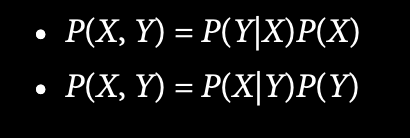

None
torch.Size([1, 138, 1054])


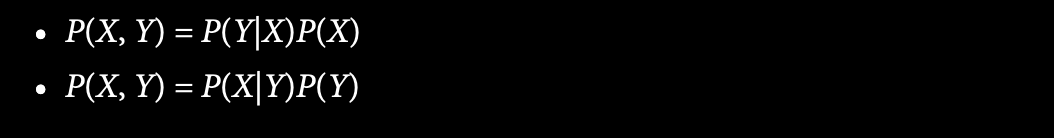

None

Predicted formula:
 <S> \begin{array} { c c } { . } & { P ( X , Y ) = P ( Y ) P ( Y ) P ( Y ) } \\ { } & { } & { P ( X , Y ) P ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(41, 178, 3)


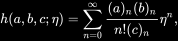

None
torch.Size([1, 41, 647])


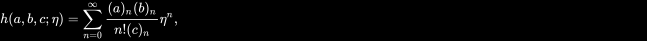

None

Predicted formula:
 <S> _ { ( \Lambda _ { A } , _ { A } , = \frac { 2 } { + + \frac { 4 } { N _ { + } } + \frac { 4 } { N _ { + } } + \frac { { } { N _ { N } } } { N _ { + } + } } } = \ldots . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


<IPython.core.display.Math object>

None
(116, 516, 3)


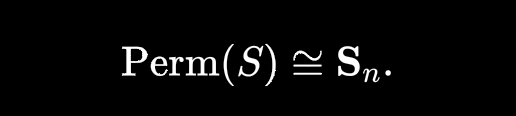

None
torch.Size([1, 116, 971])


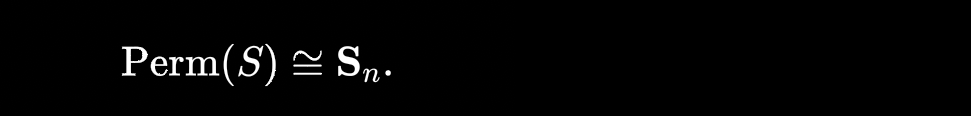

None

Predicted formula:
 <S> \begin{array} { c c } { } & { } & { } & { } & { } & { } \\ { \mathrm { P e r m } } \\ \end{array} ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


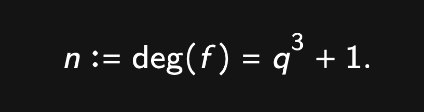

None
torch.Size([1, 112, 964])


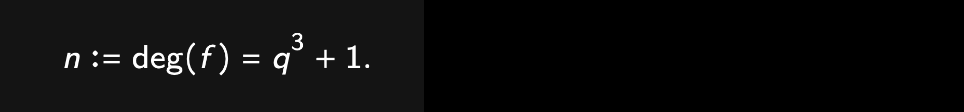

None

Predicted formula:
 <S> \begin{array} { c c c } { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ \end{array} = \mathrm { t e } e ^ { 8 } \star 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 658, 3)


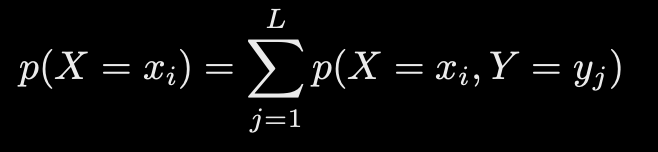

None
torch.Size([1, 152, 1128])


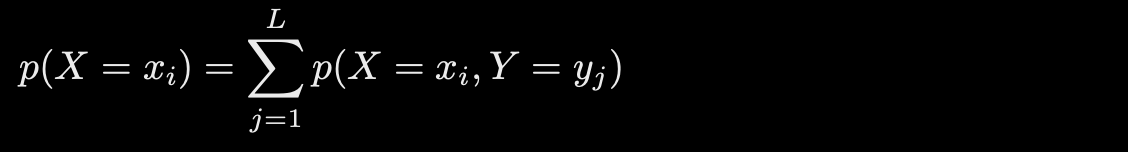

None

Predicted formula:
 <S> \begin{array} { c c } { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(320, 1080, 3)


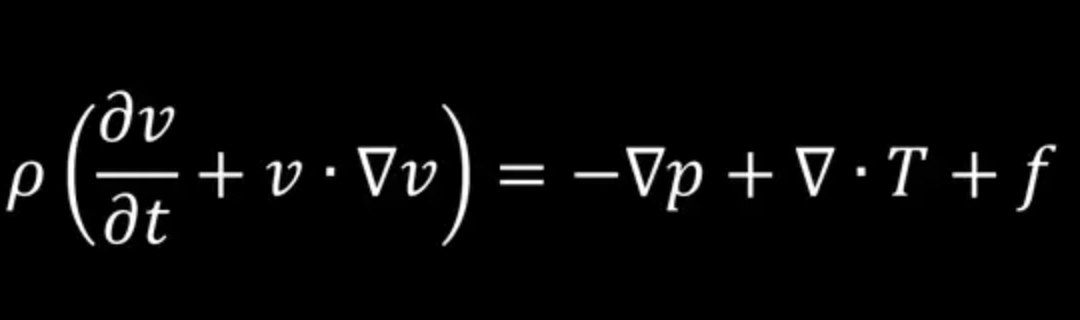

None
torch.Size([1, 320, 1672])


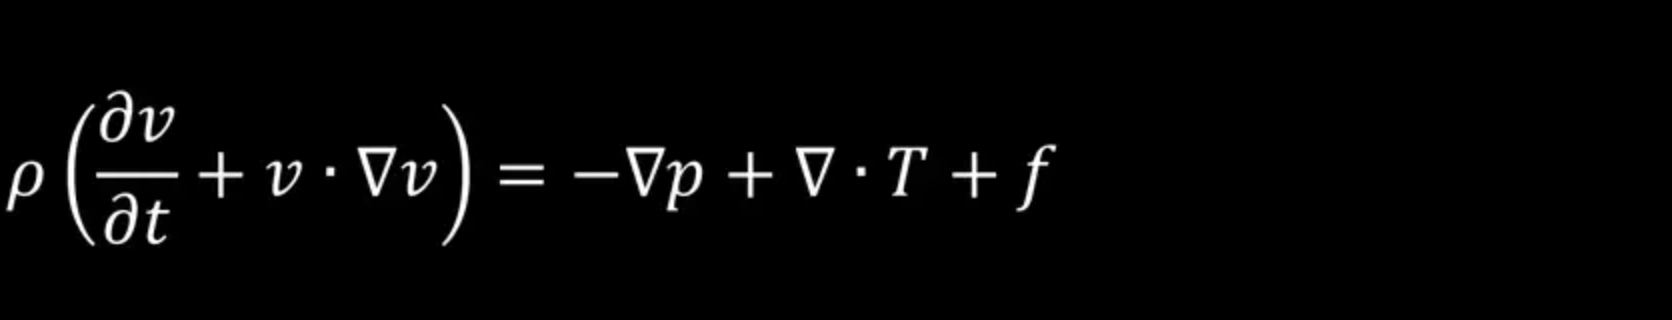

None

Predicted formula:
 <S> \rho \left( \frac { \partial r } { \partial t } { \bf r } \cdot { \bf V } \right) = - { \bf \Psi } { \bf { \bf r } } \cdot { \bf V } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(200, 1424, 3)


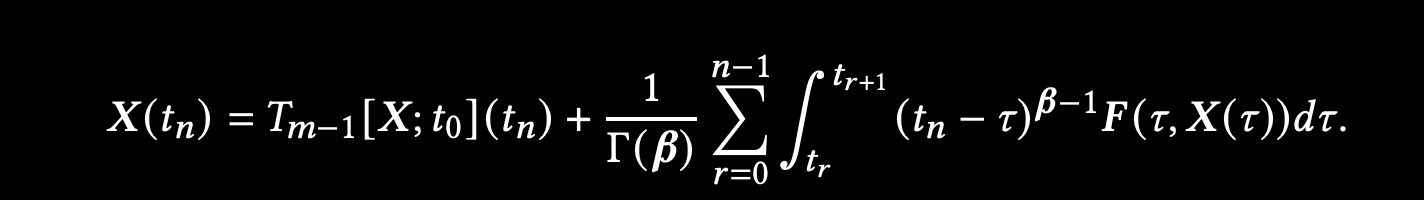

None
torch.Size([1, 200, 1537])


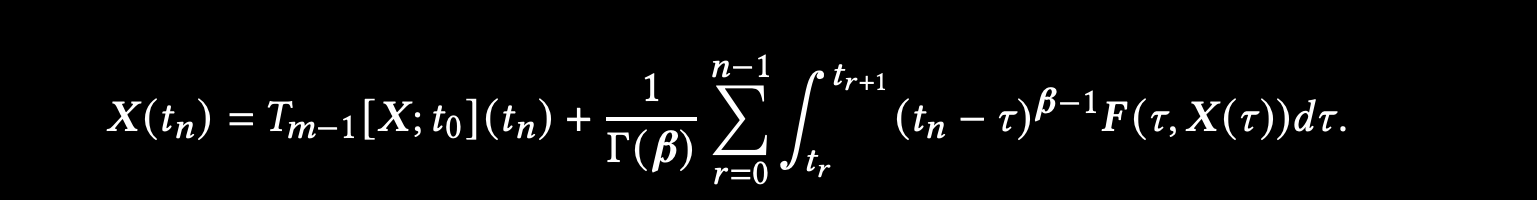

None

Predicted formula:
 <S> \qquad X ( t _ { m } ) = T _ { m - 1 } [ X \chi ; 0 ] ( \tau _ { r } ) \star \frac { 1 } { \Gamma ( \rho ) } \sum _ { \tau = 0 } ^ { r _ { r + 1 } } \int _ { \tau _ { r + 1 } } ^ { r _ { r + 1 } } ( t _ { r } ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


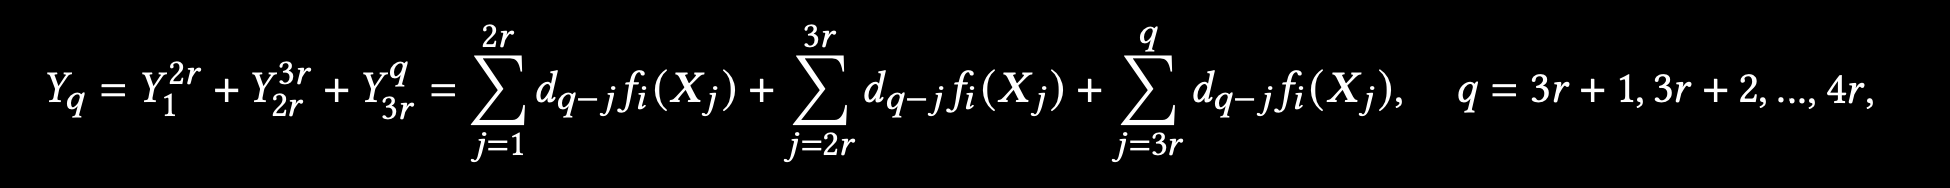

None
torch.Size([1, 188, 1950])


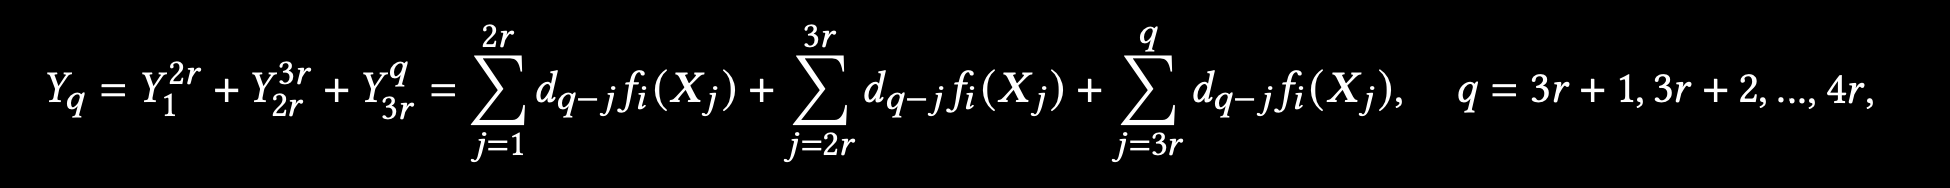

None

Predicted formula:
 <S> \begin{array} { c c } { Y _ { q } = Y _ { 1 } ^ { 2 r } \star Y _ { 2 r } ^ { 2 r } \star Y _ { 3 r } ^ { 4 } = \sum _ { j = 1 } d _ { T - j f } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 2 r } d _ { q - j } f _ { l } ( X _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(202, 1774, 3)


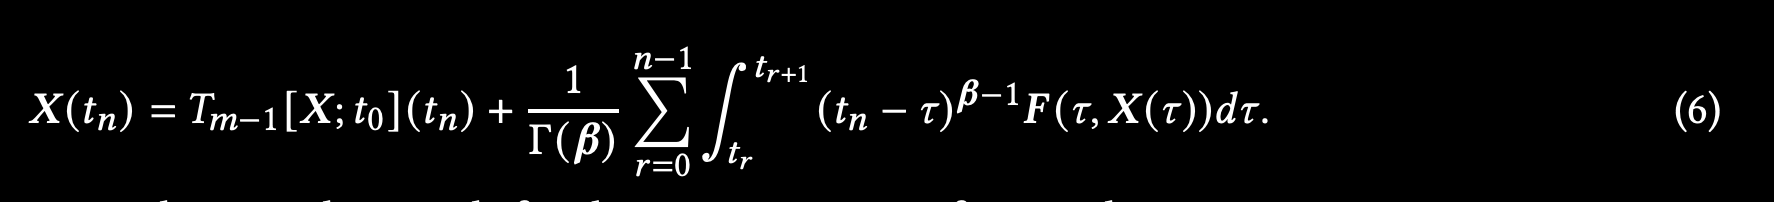

None
torch.Size([1, 202, 1774])


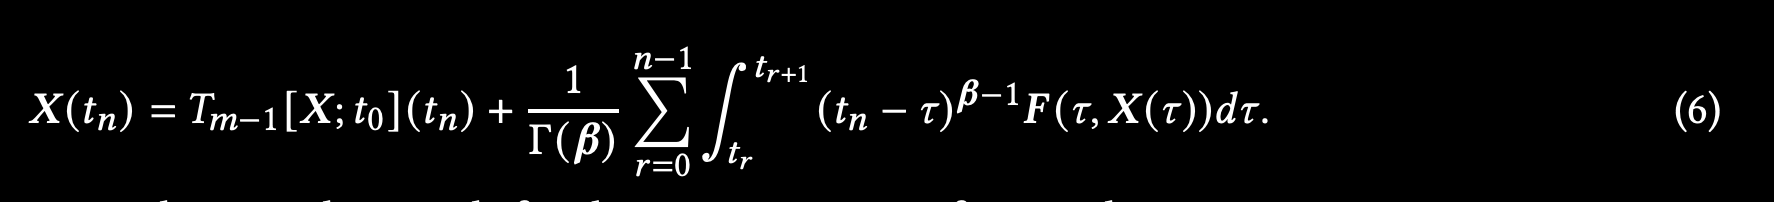

None

Predicted formula:
 <S> \begin{array} { c c c } { X ( t _ { m } ) = T _ { m - 1 } [ X _ { i } ; t ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \rho ) } \sum _ { r _ { r } } ^ { r + 1 } \int _ { r _ { r } } ^ { r + 1 } ( t _ { r } - r ) ^ { 2 } } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


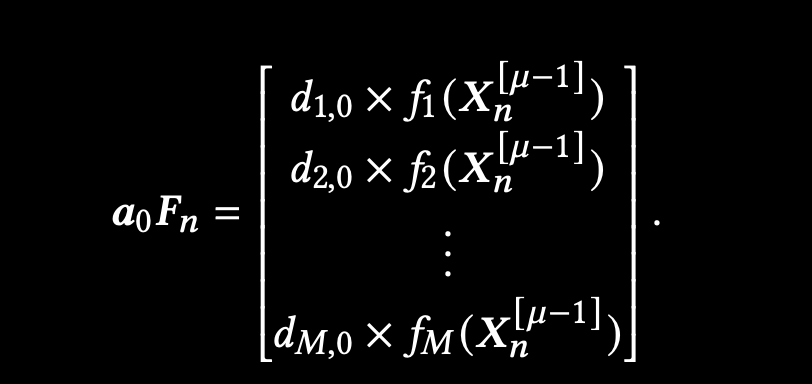

None
torch.Size([1, 384, 1566])


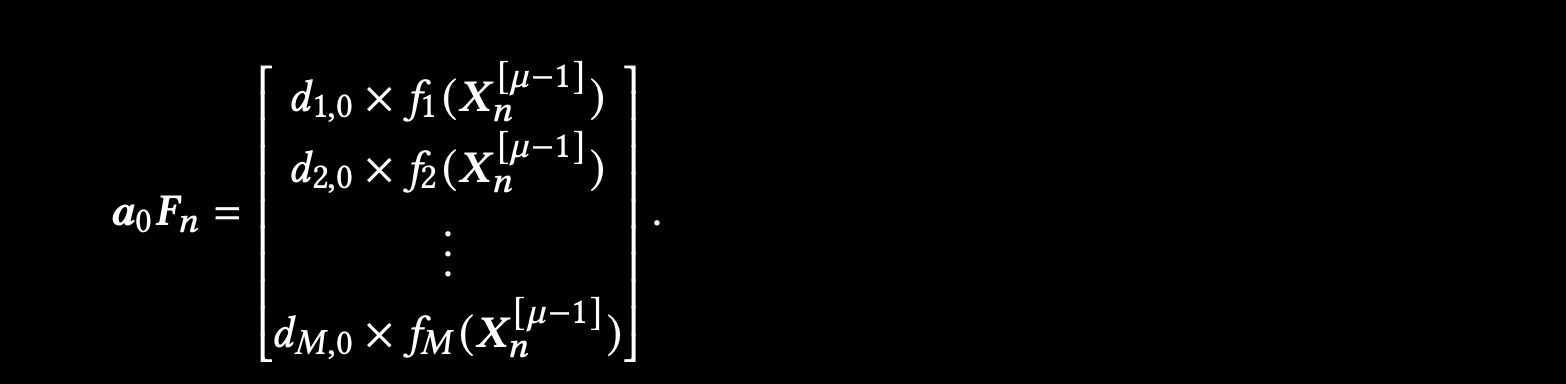

None

Predicted formula:
 <S> \qquad \begin{array} { c c } { } & { } & { } \\ { } & { } & { } & { } \\ { d _ { 1 0 } \times f _ { M } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


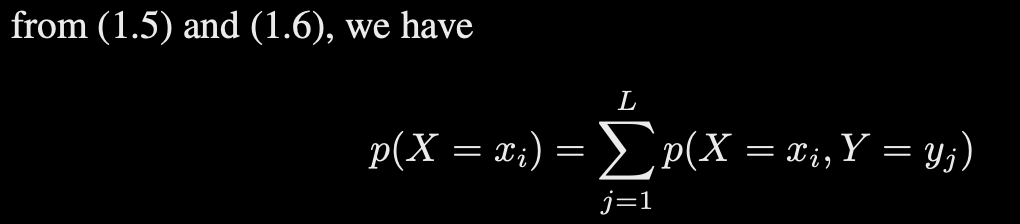

None
torch.Size([1, 224, 1462])


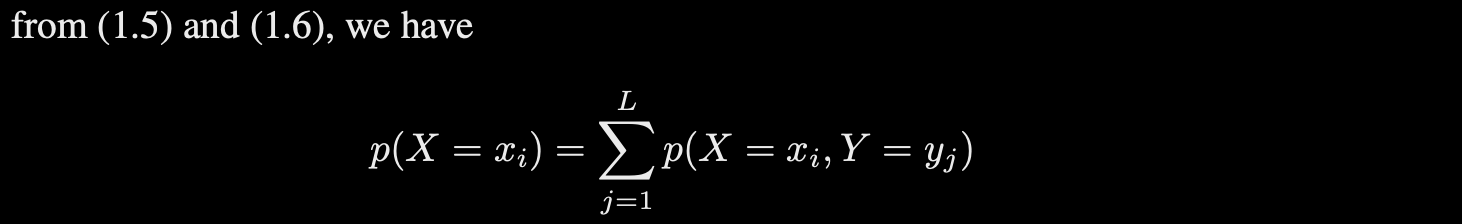

None

Predicted formula:
 <S> \begin{array} { c c } { \mathrm { f o m } ( 1 5 ) \, \mathrm { a n d } \, ( 1 , \mathrm { o r } ) \, \mathrm { w e } = x _ { i } , Y = y _ { j } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


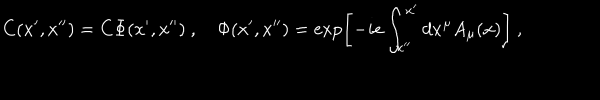

None
torch.Size([1, 100, 856])


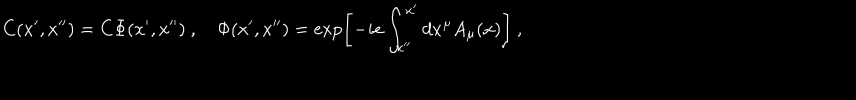

None

Predicted formula:
 <S> \begin{array} { c c c } { C ( \chi \times z ) - \{ z \times \chi [ - \sum _ { 1 } ^ { * } \chi _ { \nu } ] - \gamma [ \omega ] - \chi ] ^ { - \alpha } \chi _ { \mu } ( \nu , \nu ) } \\ { } & { } \\ { } & { } \\ \end{array} \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None
(128, 228, 3)


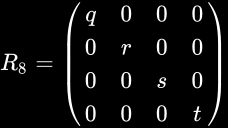

None
torch.Size([1, 128, 1024])


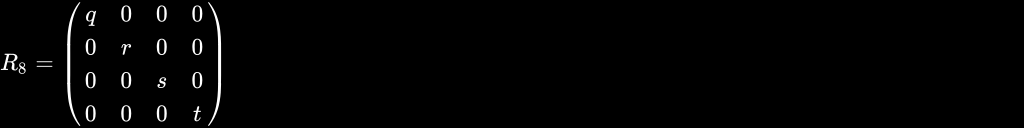

None

Predicted formula:
 <S> R _ { R } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3260, 3)


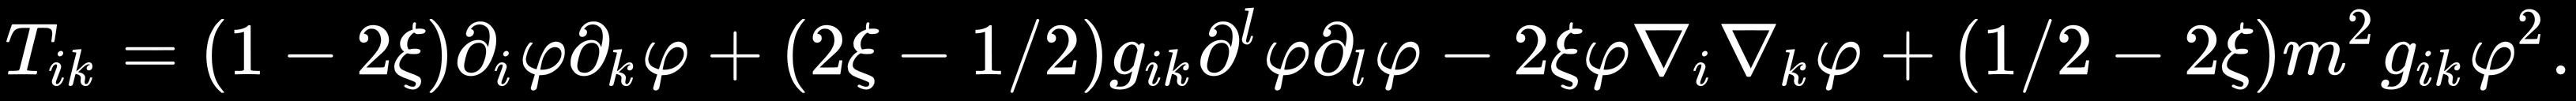

None
torch.Size([1, 128, 3260])


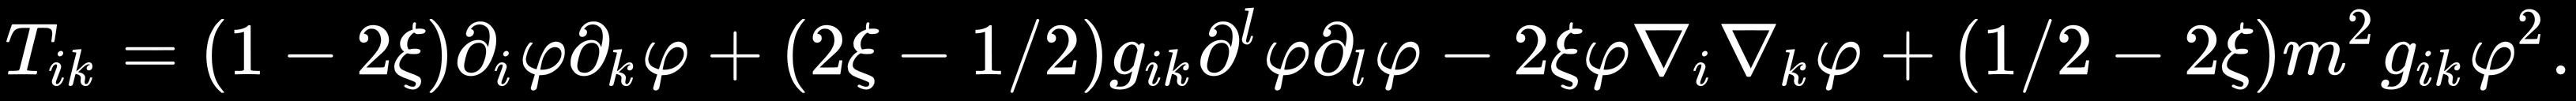

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi ) . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(150, 852, 3)


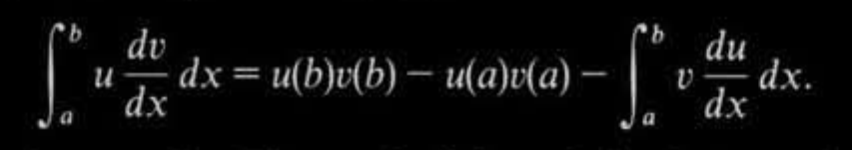

None
torch.Size([1, 150, 1149])


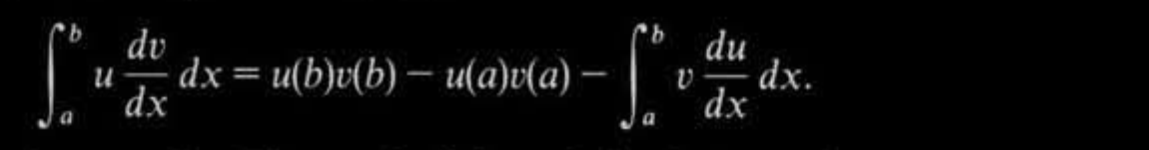

None

Predicted formula:
 <S> \mathrm { ~ } _ { \bf J } ^ { \bf \mu } { \bf k } { \bf k } ^ { \bf k } { \bf x } = { \bf u w | { \bf k } } { \bf k } { \bf k } { \bf k } { \bf { \bf k } } - { \bf l } ^ { \bf { \bf ~ } } { \bf { \bf k } } { \bf { \bf k } } { \bf { \bf x } } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 1128, 3)


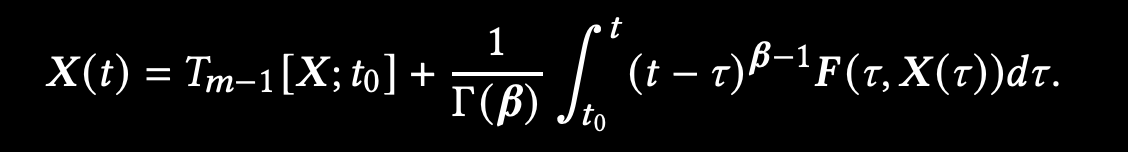

None
torch.Size([1, 152, 1203])


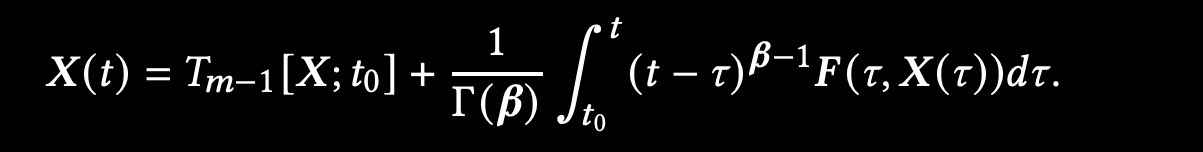

None

Predicted formula:
 <S> \begin{array} { c c } { \ \ \ \ \ \ \ X ( t ) = I _ { m - 1 } [ X ; t _ { 0 } ] } \\ { \cal I ( p , t _ { 0 } ) } \\ \end{array} \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None
(384, 812, 3)


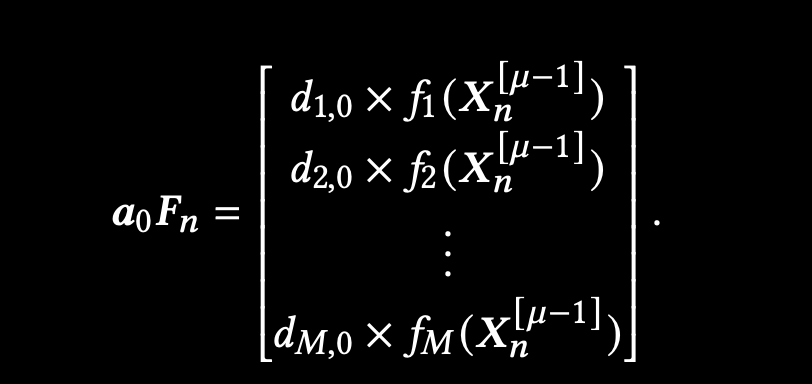

None
torch.Size([1, 384, 1566])


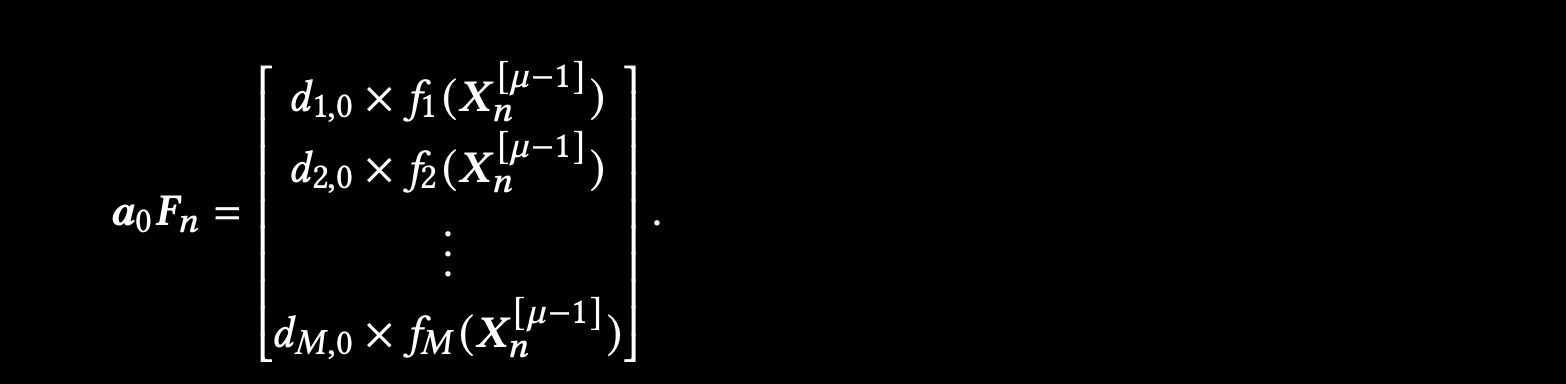

None

Predicted formula:
 <S> \qquad \begin{array} { c c } { } & { } & { } \\ { } & { } & { } & { } \\ { d _ { 1 0 } \times f _ { M } ( X _ { n } ^ { [ \mu - 1 ] } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


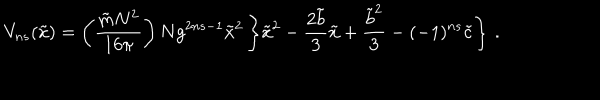

None
torch.Size([1, 100, 856])


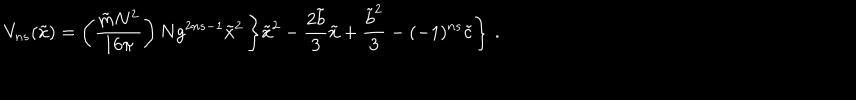

None

Predicted formula:
 <S> \begin{array} { c c } { \chi _ { c } \sigma _ { A } = \frac { X ^ { 2 } } { \lambda } \sum _ { A } ^ { 2 } \omega - \frac { \beta _ { A } } { 2 } \sum ^ { 2 } z ^ { 2 } - \frac { \beta _ { x } } { 2 } } \\ { 1 } \\ \end{array} \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None
(100, 600, 3)


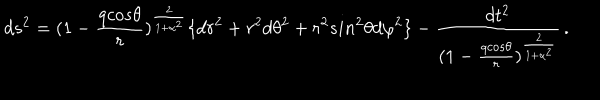

None
torch.Size([1, 100, 856])


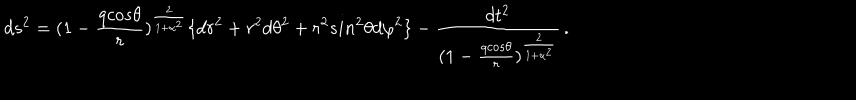

None

Predicted formula:
 <S> \begin{array} { l l } { A ^ { 2 } = - ( - - \frac { e s + c s } { 2 } ) = \phi \phi ^ { 2 } + \lambda ^ { 2 } + \lambda ^ { 2 } + \phi ^ { 4 } + \frac { 8 } { \sqrt { - e ^ { 2 } } } } \\ { } \\ { } \\ \end{array} \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \! \!


<IPython.core.display.Math object>

None
(224, 1020, 3)


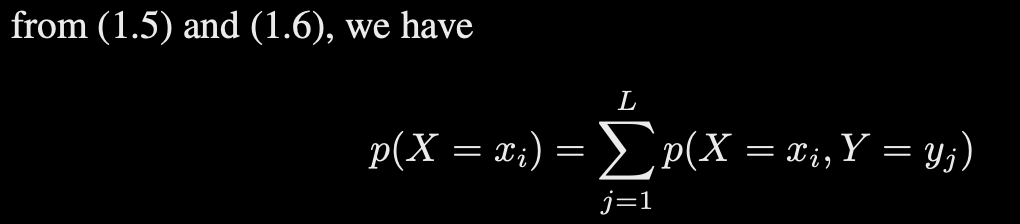

None
torch.Size([1, 224, 1462])


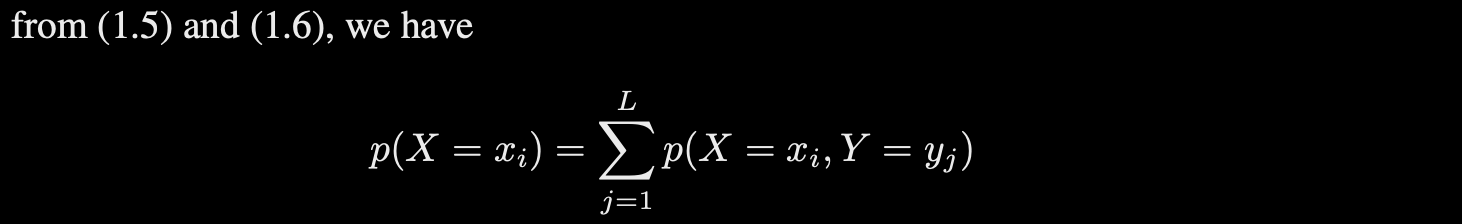

None

Predicted formula:
 <S> \begin{array} { c c } { \mathrm { f o m } ( 1 5 ) \, \mathrm { a n d } \, ( 1 , \mathrm { o r } ) \, \mathrm { w e } = x _ { i } , Y = y _ { j } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


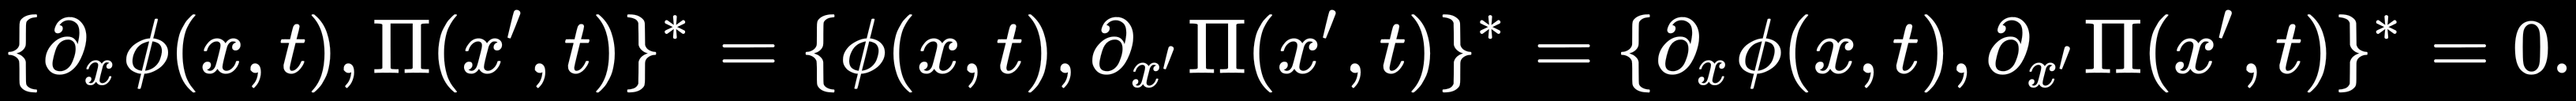

None
torch.Size([1, 128, 3264])


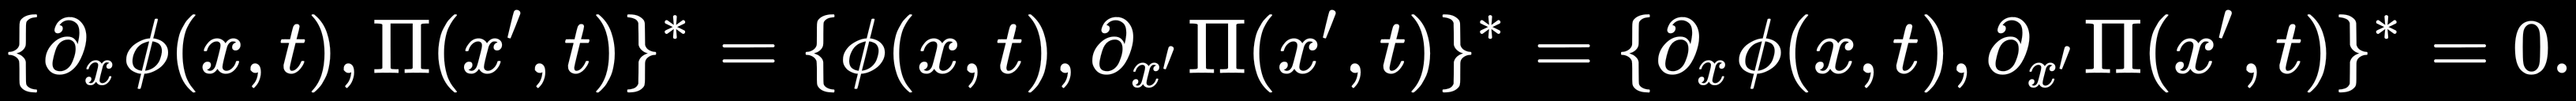

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) \} . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


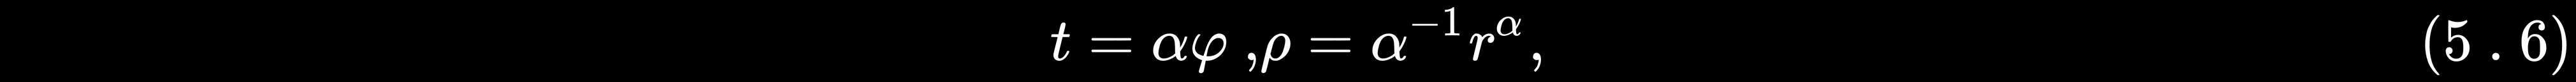

None
torch.Size([1, 128, 4042])


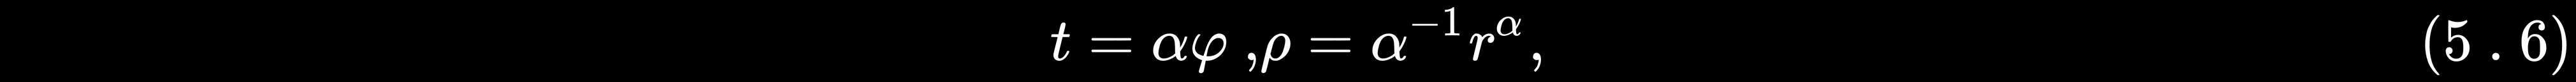

None

Predicted formula:
 <S> { \cal C } _ { i } = \alpha ^ { - 1 } r ^ { \alpha } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 9794, 3)


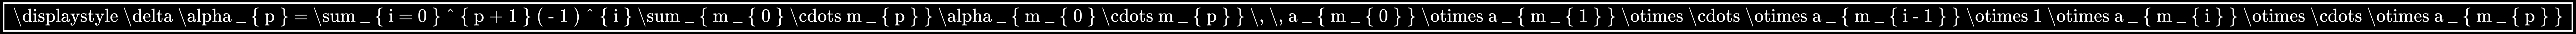

None
torch.Size([1, 128, 9794])


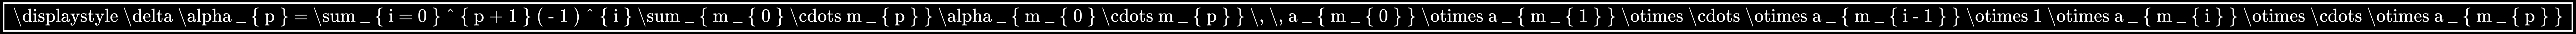

None

Predicted formula:
 <S> \square \stackrel { \mathrm { d i x p l a y y l e } } { \sum _ { } \otimes \mathrm { a t i m e s ~ } \; | \mathrm { a l i n e } \; . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [13]:
for image in IMAGES:
    predict(image)

In [11]:
# OLD FUNCTIONS


def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 160
    max_W = 1280

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    #if h<128 and w<1024:
        #image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    